# Make figures and analysis of the hindcast experiment with increase in CO2

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import xarray as xr
import scipy as sci
import h5py as h5

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

# regridding package
import xesmf as xe

# statistics package
import skill_metrics as sm


# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("xarray version =", xr.__version__)
print("scipy version =", sci.__version__)
print("h5py version =", h5.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("xesmf version =", xe.__version__)


wrkdir = "/g/data/es60/pjb581/liteexps"
os.chdir(wrkdir)


python version = 3.10.
numpy version = 1.26.4
pandas version = 2.2.1
xarray version = 2023.6.0
scipy version = 1.12.0
h5py version = 3.9.0
matplotlib version = 3.8.0
cmocean version = v3.0.3
cartopy version = 0.22.0
xesmf version = 0.8.5


## Load model data (mol C m-2 yr-1)

In [2]:
### WOMBAT-lite
dic = xr.open_dataset("hindcast/dic.nc")['dic'].squeeze()
adic = xr.open_dataset("hindcast/adic.nc")['adic'].squeeze()
co2f = xr.open_dataset("hindcast/stf07.nc")['stf07'].squeeze() * 86400.0 * 365.0 * 1e-3
aco2f = xr.open_dataset("hindcast/stf09.nc")['stf09'].squeeze() * 86400.0 * 365.0 * 1e-3

lon_mod = co2f.coords['xt_ocean']
lat_mod = co2f.coords['yt_ocean']

### old model output (Hakase)
co2f_old = xr.open_dataset("hindcast/stf07_legacy.nc")['fgco2nat_raw'].squeeze() * 86400.0 * 365.0 * 1e-3
aco2f_old = xr.open_dataset("hindcast/stf09_legacy.nc")['fgco2_raw'].squeeze() * 86400.0 * 365.0 * 1e-3


## get the model area data

In [3]:
area_mod = xr.open_dataset("ocean-2d-area_t.nc")['area_t'].squeeze()
area_mod


<xarray.DataArray 'area_t' (yt_ocean: 300, xt_ocean: 360)>
[108000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t

## load the river flux datasets to remove their contribution from the surface flux (mol C m-2 yr-1)

In [4]:
rivdic = xr.open_dataset("../wombat_files/mom_1deg_new/rivdic.nc", decode_times=False)['rivdic'].squeeze() * 365.0 * 86400.0 * 1e-3
rivdoc = xr.open_dataset("../wombat_files/mom_1deg_new/rivdoc.nc", decode_times=False)['rivdoc'].squeeze() * 365.0 * 86400.0 * 1e-3

rivdic = rivdic.rename({"grid_y_T":"yt_ocean", "grid_x_T":"xt_ocean"})
rivdoc = rivdoc.rename({"grid_y_T":"yt_ocean", "grid_x_T":"xt_ocean"})

rivcar = (rivdic + rivdoc).mean(dim='time')
rivcar


<xarray.DataArray (yt_ocean: 300, xt_ocean: 360)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.31 89.75
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5

## remove the river fluxes of carbon from the surface fluxes

In [5]:
co2f_noriv = co2f - rivcar.values
aco2f_noriv = aco2f - rivcar.values


## get the carbon flux observations (mol C m-2 yr-1)

In [6]:

all_years_data = []
all_years_err = []

for yr in np.arange(1985,2019,1):
    print(yr)
    ### Copernicus CO2 fluxes
    co201_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0115T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2']
    co202_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0215T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2']
    co203_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0315T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2']
    co204_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0415T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2']
    co205_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0515T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2']
    co206_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0615T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2']
    co207_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0715T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2']
    co208_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0815T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2']
    co209_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0915T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2']
    co210_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i1015T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2']
    co211_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i1115T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2']
    co212_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i1215T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2']
    co2_cop = xr.concat([co201_cop, co202_cop, co203_cop, co204_cop, co205_cop, co206_cop, co207_cop, co208_cop, co209_cop, co210_cop, co211_cop, co212_cop], dim="time")
    co2_cop = co2_cop.rename({"time":"month"})
    del co201_cop, co202_cop, co203_cop, co204_cop, co205_cop, co206_cop, co207_cop, co208_cop, co209_cop, co210_cop, co211_cop, co212_cop
    all_years_data.append(co2_cop)

    co201_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0115T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2_uncertainty']
    co202_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0215T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2_uncertainty']
    co203_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0315T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2_uncertainty']
    co204_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0415T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2_uncertainty']
    co205_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0515T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2_uncertainty']
    co206_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0615T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2_uncertainty']
    co207_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0715T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2_uncertainty']
    co208_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0815T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2_uncertainty']
    co209_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i0915T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2_uncertainty']
    co210_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i1015T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2_uncertainty']
    co211_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i1115T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2_uncertainty']
    co212_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_%i1215T0000Z_P20230821T1545Z.nc"%(yr), decode_times=True)['fgco2_uncertainty']
    co2_cop = xr.concat([co201_cop, co202_cop, co203_cop, co204_cop, co205_cop, co206_cop, co207_cop, co208_cop, co209_cop, co210_cop, co211_cop, co212_cop], dim="time")
    co2_cop = co2_cop.rename({"time":"month"})
    del co201_cop, co202_cop, co203_cop, co204_cop, co205_cop, co206_cop, co207_cop, co208_cop, co209_cop, co210_cop, co211_cop, co212_cop
    all_years_err.append(co2_cop)

lon_cop = co2_cop.coords['longitude']
lat_cop = co2_cop.coords['latitude']

co2_cop = xr.concat(all_years_data, dim='month')
err_cop = xr.concat(all_years_err, dim='month')
co2_cop


1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


<xarray.DataArray 'fgco2' (month: 408, latitude: 713, longitude: 1440)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * month      (month) datetime64[ns] 1985-01-15 1985-02-15 ... 2018-12-15
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -88.12 -87.88 -87.62 ... 89.38 89.62 89.88
Attributes:
    standard_name:  surface_downward_mass_flux_of_carbon_dioxide_expressed_as...
    long_name:      Surface downward flux of total CO2
    units:          molC m-2 yr-1

## load the area dataset

In [7]:
area_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/LSCE_surface_ocean_area_r025.nc", decode_times=True)['area'] * 1e6
area_cop = area_cop.rename({"lat":"latitude", "lon":"longitude"})
area_cop = area_cop.sel(latitude=slice(-88.13,89.88))
area_cop


<xarray.DataArray 'area' (latitude: 713, longitude: 1440)>
array([[25284220. , 25284220. , 25284220. , ..., 25284220. , 25284220. ,
        25284220. ],
       [28662488. , 28662488. , 28662488. , ..., 28662488. , 28662488. ,
        28662488. ],
       [32019638. , 32019638. , 32019638. , ..., 32019638. , 32019638. ,
        32019638. ],
       ...,
       [ 8424554. ,  8424554. ,  8424554. , ...,  8424554. ,  8424554. ,
         8424554. ],
       [ 5056844. ,  5056844. ,  5056844. , ...,  5056844. ,  5056844. ,
         5056844. ],
       [ 1689133.6,  1689133.6,  1689133.6, ...,  1689133.6,  1689133.6,
         1689133.6]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -88.12 -87.88 -87.62 ... 89.38 89.62 89.88

## calculate the integrated area-sea flux for model and data

In [8]:
### model
co2f_noriv_int = (co2f_noriv * area_mod).sum(dim=['xt_ocean','yt_ocean']) * 12 * 1e-15
aco2f_noriv_int = (aco2f_noriv * area_mod).sum(dim=['xt_ocean','yt_ocean']) * 12 * 1e-15

co2f_old_int = (co2f_old * area_mod).sum(dim=['xt_ocean','yt_ocean']) * 12 * 1e-15
aco2f_old_int = (aco2f_old * area_mod).sum(dim=['xt_ocean','yt_ocean']) * 12 * 1e-15

### observational product 
co2_cop_int = (co2_cop * area_cop).sum(dim=['longitude','latitude']) * 12 * 1e-15
err_cop_int = (err_cop * area_cop).sum(dim=['longitude','latitude']) * 12 * 1e-15



## make a timeseries figure

In [9]:
print(co2_cop_int.rolling(month=12, center=True).mean().sel(month=slice('2017-01-01', '2019-01-01')))
print(err_cop_int.rolling(month=12, center=True).mean().sel(month=slice('2017-01-01', '2019-01-01')))

print(aco2f_noriv_int.rolling(time=12, center=True).mean().sel(time=slice('2017-01-01', '2019-01-01')))
print(aco2f_old_int.rolling(time=12, center=True).mean().sel(time=slice('2017-01-01', '2019-01-01')))


<xarray.DataArray (month: 24)>
array([2.3943505, 2.409146 , 2.423489 , 2.4328794, 2.4320846, 2.41362  ,
       2.4100208, 2.3744514, 2.3591945, 2.3410058, 2.357187 , 2.3673441,
       2.3727674, 2.3526044, 2.347453 , 2.3681211, 2.3773148, 2.3919199,
       2.3982928,       nan,       nan,       nan,       nan,       nan],
      dtype=float32)
Coordinates:
  * month    (month) datetime64[ns] 2017-01-15 2017-02-15 ... 2018-12-15
<xarray.DataArray (month: 24)>
array([1.901891 , 1.9037693, 1.9184265, 1.9219685, 1.918911 , 1.9215096,
       1.926348 , 1.9283674, 1.9304312, 1.9234607, 1.9219508, 1.930435 ,
       1.9366169, 1.9532964, 1.9579339, 1.955729 , 1.9607801, 1.9573982,
       1.9643874,       nan,       nan,       nan,       nan,       nan],
      dtype=float32)
Coordinates:
  * month    (month) datetime64[ns] 2017-01-15 2017-02-15 ... 2018-12-15
<xarray.DataArray (time: 24)>
array([2.34016225, 2.29075942, 2.25679833, 2.21650467, 2.16784139,
       2.12467105, 2.0800739 , 2.04064672

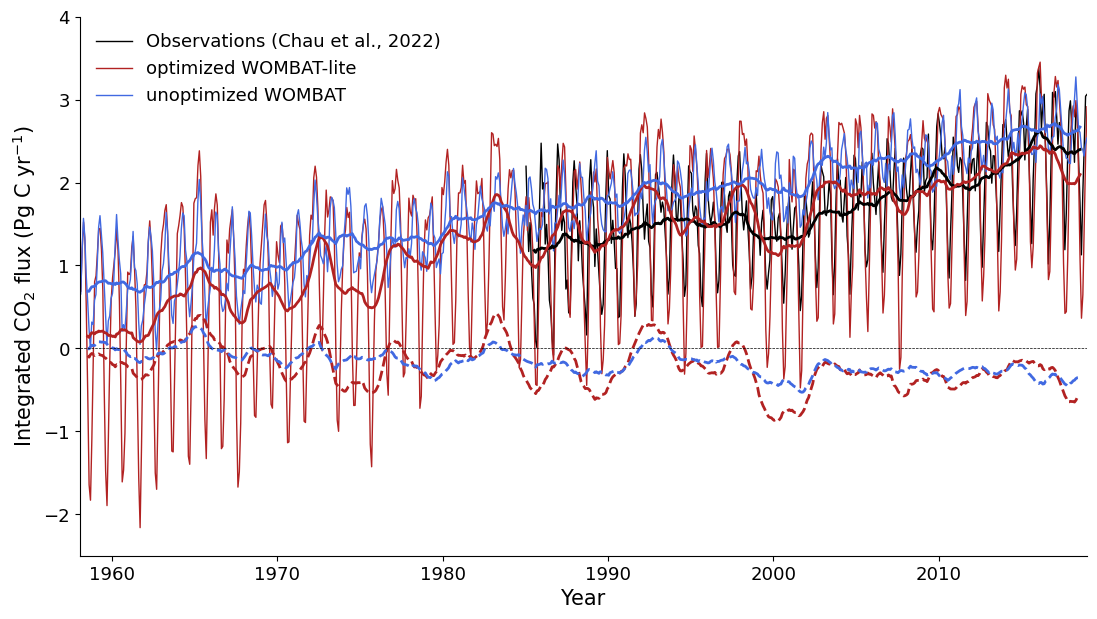

In [11]:
fstic = 13
fslab = 15

cols = ['k', 'firebrick', 'royalblue']
lwid = [2.0, 2.0, 2.0]
lsty = ['-', '-', '-']
alf = [1.0, 1.0, 1.0]
labs = ['Observations (Chau et al., 2022)', 'optimized WOMBAT-lite', 'unoptimized WOMBAT']

fig = plt.figure(figsize=(13,7))
gs = GridSpec(1,1)

ax1 = plt.subplot(gs[0])
ax1.tick_params(labelsize=fstic)
ax1.spines[['top','right']].set_visible(False)

ax1.plot(co2_cop_int.coords['month'], co2_cop_int, color=cols[0], linewidth=lwid[0]*0.5, linestyle=lsty[0], alpha=alf[0], label=labs[0])
ax1.plot(aco2f_noriv_int.coords['time'], aco2f_noriv_int, color=cols[1], linewidth=lwid[1]*0.5, linestyle=lsty[1], alpha=alf[1], label=labs[1])
ax1.plot(aco2f_old_int.coords['time'], aco2f_old_int, color=cols[2], linewidth=lwid[2]*0.5, linestyle=lsty[2], alpha=alf[2], label=labs[2])
#ax1.plot(co2f_noriv_int.coords['time'], co2f_noriv_int, color=cols[1], linewidth=lwid[1]*0.5, linestyle='--', alpha=alf[1], label=labs[1])

ax1.plot(co2_cop_int.coords['month'], co2_cop_int.rolling(month=12, center=True).mean(), color=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
ax1.plot(aco2f_noriv_int.coords['time'], aco2f_noriv_int.rolling(time=12, center=True).mean(), color=cols[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])
ax1.plot(aco2f_old_int.coords['time'], aco2f_old_int.rolling(time=12, center=True).mean(), color=cols[2], linewidth=lwid[2], linestyle=lsty[2], alpha=alf[2])
ax1.plot(co2f_noriv_int.coords['time'], co2f_noriv_int.rolling(time=12, center=True).mean(), color=cols[1], linewidth=lwid[1], linestyle='--', alpha=alf[1])
ax1.plot(co2f_old_int.coords['time'], co2f_old_int.rolling(time=12, center=True).mean(), color=cols[2], linewidth=lwid[2], linestyle='--', alpha=alf[2])

# zero line
ax1.plot(co2f_noriv_int.coords['time'], co2f_noriv_int*0, color='k', linewidth=0.5, linestyle='--', alpha=1.0, zorder=3)

ax1.legend(frameon=False, ncol=1, loc='upper left', fontsize=fstic)

ax1.set_xlabel('Year', fontsize=fslab)
ax1.set_ylabel('Integrated CO$_2$ flux (Pg C yr$^{-1}$)', fontsize=fslab)
ax1.set_xlim(aco2f_noriv_int.coords['time'].min(), aco2f_noriv_int.coords['time'].max())
ax1.set_ylim(-2.5,4)


os.chdir(wrkdir)
fig.savefig("figures/hindcast_co2fluxes.png", dpi=300)
fig.savefig("figures/hindcast_co2fluxes.pdf", dpi=300)
fig.savefig("figures/hindcast_co2fluxes_transparent.png", dpi=300, transparent=True)


## calculate the running correlation coefficient for CO2 fluxes (global, and by latitude band)

### we have to regrid the model and the observations to a common grid for direct comparison

In [12]:
### choose regular grid for regridding
ds_out = xe.util.grid_global(1,1)
lon_reg = ds_out.coords['lon']
lat_reg = ds_out.coords['lat']


### regrid the observations

In [13]:
### regrid the CO2 fluxes
lons_cop, lats_cop = np.meshgrid(lon_cop, lat_cop)
ds_in = xr.Dataset(
    {'co2_cop': ( ('month', 'y', 'x'), co2_cop.values),
     },
    coords={"lon": (['y','x'], lons_cop),
            "lat": (['y','x'], lats_cop),
            "month": (['month'], co2_cop.coords['month'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
co2_cop_reg = regridder(ds_in['co2_cop'])
co2_cop_reg


<xarray.DataArray (month: 408, y: 180, x: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * month    (month) datetime64[ns] 1985-01-15 1985-02-15 ... 2018-12-15
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  nearest_s2d

### regrid the model

In [14]:
lons_mod, lats_mod = np.meshgrid(lon_mod, lat_mod)

ds_in = xr.Dataset(
    {'co2_mod': ( ('month', 'y', 'x'), co2f_noriv.values),
     'aco2_mod': ( ('month', 'y', 'x'), aco2f_noriv.values),
     'co2_old': ( ('month', 'y', 'x'), co2f_old.values),
     'aco2_old': ( ('month', 'y', 'x'), aco2f_old.values),
    },
    coords={"lon": (['y','x'], lons_mod),
            "lat": (['y','x'], lats_mod),
            "month": (['month'], co2f_noriv.coords['time'].values),
            }
    )

### regrid
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
co2_mod_reg = regridder(ds_in['co2_mod'])
aco2_mod_reg = regridder(ds_in['aco2_mod'])
co2_old_reg = regridder(ds_in['co2_old'])
aco2_old_reg = regridder(ds_in['aco2_old'])

### match the time dimension and units with the observation array
aco2_mod_reg = aco2_mod_reg.sel(month=slice('1985-01-01','2019-01-01'))
aco2_mod_reg = aco2_mod_reg.assign_coords({"month": co2_cop_reg.coords['month'].values})

aco2_old_reg = aco2_old_reg.sel(month=slice('1985-01-01','2019-01-01'))
aco2_old_reg = aco2_old_reg.assign_coords({"month": co2_cop_reg.coords['month'].values})


### make zonal and seasonal comparison figures

#### calculate areas of the regular grid

In [15]:
import pyproj
geod = pyproj.Geod(ellps="WGS84")

lon_edges = np.concatenate((np.array([-180.0]), lon_reg.isel(y=0).values + lon_reg.isel(y=0).diff('x').mean().values*0.5))
lat_edges = np.concatenate((np.array([-90.0]), lat_reg.isel(x=0).values + lat_reg.isel(x=0).diff('latitude').mean().values*0.5))

def find_grid_distances(lon_edges, lat_edges):
    lat_distances = np.zeros((len(lat_edges)-1, len(lon_edges)-1))
    lon_distances = np.zeros((len(lat_edges)-1, len(lon_edges)-1))
    for i in range(len(lat_edges)-1):
        for j in range(len(lon_edges)-1):
            # Calculate the latitudinal distance (north-south) for this grid cell
            _, _, lat_distance = geod.inv(lon_edges[j], lat_edges[i], lon_edges[j], lat_edges[i+1])
            lat_distances[i, j] = lat_distance
            
            # Calculate the longitudinal distance (east-west) at the northern edge of the grid cell
            _, _, lon_distance_north = geod.inv(lon_edges[j], lat_edges[i+1], lon_edges[j+1], lat_edges[i+1])
            
            # Calculate the longitudinal distance (east-west) at the southern edge of the grid cell
            _, _, lon_distance_south = geod.inv(lon_edges[j], lat_edges[i], lon_edges[j+1], lat_edges[i])
            
            # Average the distances at the northern and southern edges for a more accurate estimate
            lon_distances[i, j] = (lon_distance_north + lon_distance_south) / 2
            
    
    return lat_distances, lon_distances


lat_distances, lon_distances = find_grid_distances(lon_edges, lat_edges)


In [16]:
area = lon_distances * lat_distances

dsarea = xr.Dataset(
    {'area': ( ('y', 'x'), area),
     },
    coords={"lon": (['y', 'x'], lon_reg.values),
            "lat": (['y', 'x'], lat_reg.values),
            }
)

area_reg = dsarea['area']

#### compare zonal integrals

In [17]:
### compute the zonal sums of the observations
co2_cop_tmp = (co2_cop_reg * area_reg).sum(dim='x', skipna=True).sel(month=slice('1990-01-01','2010-01-01'))*12*1e-12
co2_cop_tmp = co2_cop_tmp.where(co2_cop_tmp != 0.0, other=np.nan)
co2_cop_zonal = co2_cop_tmp.mean(dim='month', skipna=True)
co2_cop_zonal_jfm = co2_cop_tmp.where(co2_cop_tmp.coords['month'].dt.month.isin([1,2,3]), drop=True).mean(dim='month')
co2_cop_zonal_jas = co2_cop_tmp.where(co2_cop_tmp.coords['month'].dt.month.isin([7,8,9]), drop=True).mean(dim='month')

### compute the zonal sums of the model
aco2f_noriv_tmp = (aco2_mod_reg * area_reg).sum(dim='x', skipna=True).sel(month=slice('1990-01-01','2010-01-01'))*12*1e-12
aco2f_noriv_tmp = aco2f_noriv_tmp.where(aco2f_noriv_tmp != 0.0, other=np.nan)
aco2f_noriv_zonal = aco2f_noriv_tmp.mean(dim='month', skipna=True)
aco2f_noriv_zonal_jfm = aco2f_noriv_tmp.where(aco2f_noriv_tmp.coords['month'].dt.month.isin([1,2,3]), drop=True).mean(dim='month')
aco2f_noriv_zonal_jas = aco2f_noriv_tmp.where(aco2f_noriv_tmp.coords['month'].dt.month.isin([7,8,9]), drop=True).mean(dim='month')

aco2f_old_tmp = (aco2_old_reg * area_reg).sum(dim='x', skipna=True).sel(month=slice('1990-01-01','2010-01-01'))*12*1e-12
aco2f_old_tmp = aco2f_old_tmp.where(aco2f_old_tmp != 0.0, other=np.nan)
aco2f_old_zonal = aco2f_old_tmp.mean(dim='month', skipna=True)
aco2f_old_zonal_jfm = aco2f_old_tmp.where(aco2f_old_tmp.coords['month'].dt.month.isin([1,2,3]), drop=True).mean(dim='month')
aco2f_old_zonal_jas = aco2f_old_tmp.where(aco2f_old_tmp.coords['month'].dt.month.isin([7,8,9]), drop=True).mean(dim='month')

print(co2_cop_tmp.shape)
print(aco2f_noriv_tmp.shape)
print(aco2f_old_tmp.shape)



(240, 180)
(240, 180)
(240, 180)


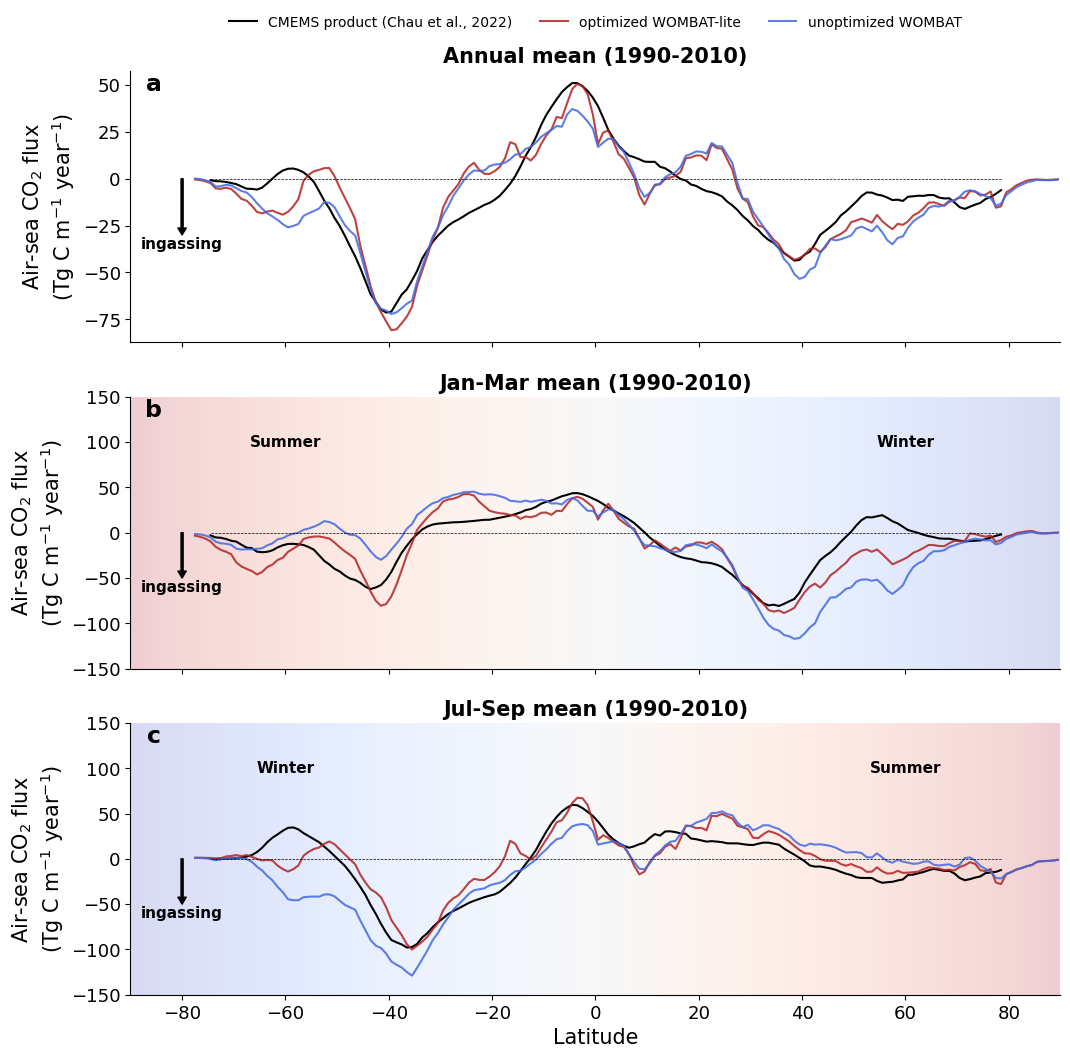

In [18]:
fstic = 13
fslab = 15

lwid = [1.5, 1.5, 1.5]
cols = ['k', 'firebrick', 'royalblue']
lsty = ['-', '-', '-']
labs = ['CMEMS product (Chau et al., 2022)', 'optimized WOMBAT-lite', 'unoptimized WOMBAT']
alf = [1.0, 0.85, 0.85]

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(3,1)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1.spines[['top', 'right']].set_visible(False)
ax2.spines[['top', 'right']].set_visible(False)
ax3.spines[['top', 'right']].set_visible(False)

ax1.tick_params(labelsize=fstic, labelbottom=False)
ax2.tick_params(labelsize=fstic, labelbottom=False)
ax3.tick_params(labelsize=fstic)

ax1.plot(lat_reg.isel(x=0).values, -co2_cop_zonal, color=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0], label=labs[0] )
ax1.plot(lat_reg.isel(x=0).values, -aco2f_noriv_zonal, color=cols[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1], label=labs[1]  )
ax1.plot(lat_reg.isel(x=0).values, -aco2f_old_zonal, color=cols[2], linewidth=lwid[2], linestyle=lsty[2], alpha=alf[2], label=labs[2]  )

ax2.plot(lat_reg.isel(x=0).values, -co2_cop_zonal_jfm, color=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0], label=labs[0] )
ax2.plot(lat_reg.isel(x=0).values, -aco2f_noriv_zonal_jfm, color=cols[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1], label=labs[1]  )
ax2.plot(lat_reg.isel(x=0).values, -aco2f_old_zonal_jfm, color=cols[2], linewidth=lwid[2], linestyle=lsty[2], alpha=alf[2], label=labs[2]  )

ax3.plot(lat_reg.isel(x=0).values, -co2_cop_zonal_jas, color=cols[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0], label=labs[0] )
ax3.plot(lat_reg.isel(x=0).values, -aco2f_noriv_zonal_jas, color=cols[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1], label=labs[1]  )
ax3.plot(lat_reg.isel(x=0).values, -aco2f_old_zonal_jas, color=cols[2], linewidth=lwid[2], linestyle=lsty[2], alpha=alf[2], label=labs[2]  )

ax1.plot(lat_reg.isel(x=0).values, co2_cop_zonal*0, color='k', linewidth=0.5, linestyle='--', alpha=1.0, zorder=3)
ax2.plot(lat_reg.isel(x=0).values, co2_cop_zonal*0, color='k', linewidth=0.5, linestyle='--', alpha=1.0, zorder=3)
ax3.plot(lat_reg.isel(x=0).values, co2_cop_zonal*0, color='k', linewidth=0.5, linestyle='--', alpha=1.0, zorder=3)

ax1.set_ylabel("Air-sea CO$_2$ flux\n(Tg C m$^{-1}$ year$^{-1}$)", fontsize=fslab)
ax2.set_ylabel("Air-sea CO$_2$ flux\n(Tg C m$^{-1}$ year$^{-1}$)", fontsize=fslab)
ax3.set_ylabel("Air-sea CO$_2$ flux\n(Tg C m$^{-1}$ year$^{-1}$)", fontsize=fslab)
ax3.set_xlabel("Latitude", fontsize=fslab)

ax1.set_xlim(-90,90); ax2.set_xlim(-90,90); ax3.set_xlim(-90,90)

ax1.annotate(
    '',  # Text to display
    xy=(-80.0,-30.0),   # The arrowhead location
    xytext=(-80.0,0.0),  # The starting point of the arrow
    xycoords='data',
    size=2,
    arrowprops=dict(facecolor='k', headwidth=6, shrink=0.0, headlength=5, width=1.5),
)
ax2.annotate(
    '',  # Text to display
    xy=(-80.0,-50.0),   # The arrowhead location
    xytext=(-80.0,0.0),  # The starting point of the arrow
    xycoords='data',
    size=2,
    arrowprops=dict(facecolor='k', headwidth=6, shrink=0.0, headlength=5, width=1.5),
)
ax3.annotate(
    '',  # Text to display
    xy=(-80.0,-50.0),   # The arrowhead location
    xytext=(-80.0,0.0),  # The starting point of the arrow
    xycoords='data',
    size=2,
    arrowprops=dict(facecolor='k', headwidth=6, shrink=0.0, headlength=5, width=1.5),
)

plt.text(-80,-35, 'ingassing', fontsize=fstic-2, fontweight='bold', ha='center', va='center', transform=ax1.transData)
plt.text(-80,-60, 'ingassing', fontsize=fstic-2, fontweight='bold', ha='center', va='center', transform=ax2.transData)
plt.text(-80,-60, 'ingassing', fontsize=fstic-2, fontweight='bold', ha='center', va='center', transform=ax3.transData)

plt.text(-60,100, 'Summer', fontsize=fstic-2, fontweight='bold', ha='center', va='center', transform=ax2.transData)
plt.text(-60,100, 'Winter', fontsize=fstic-2, fontweight='bold', ha='center', va='center', transform=ax3.transData)
plt.text(60,100, 'Winter', fontsize=fstic-2, fontweight='bold', ha='center', va='center', transform=ax2.transData)
plt.text(60,100, 'Summer', fontsize=fstic-2, fontweight='bold', ha='center', va='center', transform=ax3.transData)

xx = 0.025; yy = 0.95
plt.text(xx,yy, 'a', fontweight='bold', ha='center', va='center', fontsize=fslab+2, transform=ax1.transAxes)
plt.text(xx,yy, 'b', fontweight='bold', ha='center', va='center', fontsize=fslab+2, transform=ax2.transAxes)
plt.text(xx,yy, 'c', fontweight='bold', ha='center', va='center', fontsize=fslab+2, transform=ax3.transAxes)

xx = 0.5; yy = 1.05
plt.text(xx,yy, 'Annual mean (1990-2010)', fontweight='bold', ha='center', va='center', fontsize=fslab, transform=ax1.transAxes)
plt.text(xx,yy, 'Jan-Mar mean (1990-2010)', fontweight='bold', ha='center', va='center', fontsize=fslab, transform=ax2.transAxes)
plt.text(xx,yy, 'Jul-Sep mean (1990-2010)', fontweight='bold', ha='center', va='center', fontsize=fslab, transform=ax3.transAxes)

ax1.legend(loc='upper center', ncols=3, frameon=False, bbox_to_anchor=(0.5,1.25))

xgrad, ygrad = np.meshgrid(np.arange(-90,91,1), np.arange(-150,151,1))
ax2.imshow(xgrad, extent=[-90,90,-150,150], origin='lower', aspect='auto', cmap='coolwarm_r', alpha=0.2)
ax3.imshow(xgrad, extent=[-90,90,-150,150], origin='lower', aspect='auto', cmap='coolwarm', alpha=0.2)

os.chdir(wrkdir)
fig.savefig("figures/hindcast_co2fluxes-zonalintegral.png", dpi=300)
fig.savefig("figures/hindcast_co2fluxes-zonalintegral.pdf", dpi=300)
fig.savefig("figures/hindcast_co2fluxes-zonalintegral_transparent.png", dpi=300, transparent=True)


#### seasonality

In [19]:
### calculate the climatology between 1990-2010
co2_cop_reg_clim = co2_cop_reg.sel(month=slice('1990-01-01','2010-01-01')).groupby('month.month').mean(dim='month')
aco2_mod_reg_clim = aco2_mod_reg.sel(month=slice('1990-01-01','2010-01-01')).groupby('month.month').mean(dim='month')
aco2_old_reg_clim = aco2_old_reg.sel(month=slice('1990-01-01','2010-01-01')).groupby('month.month').mean(dim='month')


### Pearson's correlations
r_SOCO2_20to80_old = np.corrcoef((co2_cop_reg_clim*area_reg).isel(y=slice(0,70)).sum(dim=['y','x']).values, (aco2_old_reg_clim*area_reg).isel(y=slice(0,70)).sum(dim=['y','x']).values)
r_SOCO2_20to80_new = np.corrcoef((co2_cop_reg_clim*area_reg).isel(y=slice(0,70)).sum(dim=['y','x']).values, (aco2_mod_reg_clim*area_reg).isel(y=slice(0,70)).sum(dim=['y','x']).values)

r_SOCO2_20to35_old = np.corrcoef((co2_cop_reg_clim*area_reg).isel(y=slice(55,70)).sum(dim=['y','x']).values, (aco2_old_reg_clim*area_reg).isel(y=slice(55,70)).sum(dim=['y','x']).values)
r_SOCO2_20to35_new = np.corrcoef((co2_cop_reg_clim*area_reg).isel(y=slice(55,70)).sum(dim=['y','x']).values, (aco2_mod_reg_clim*area_reg).isel(y=slice(55,70)).sum(dim=['y','x']).values)

r_SOCO2_35to50_old = np.corrcoef((co2_cop_reg_clim*area_reg).isel(y=slice(40,55)).sum(dim=['y','x']).values, (aco2_old_reg_clim*area_reg).isel(y=slice(40,55)).sum(dim=['y','x']).values)
r_SOCO2_35to50_new = np.corrcoef((co2_cop_reg_clim*area_reg).isel(y=slice(40,55)).sum(dim=['y','x']).values, (aco2_mod_reg_clim*area_reg).isel(y=slice(40,55)).sum(dim=['y','x']).values)

r_SOCO2_50to65_old = np.corrcoef((co2_cop_reg_clim*area_reg).isel(y=slice(25,40)).sum(dim=['y','x']).values, (aco2_old_reg_clim*area_reg).isel(y=slice(25,40)).sum(dim=['y','x']).values)
r_SOCO2_50to65_new = np.corrcoef((co2_cop_reg_clim*area_reg).isel(y=slice(25,40)).sum(dim=['y','x']).values, (aco2_mod_reg_clim*area_reg).isel(y=slice(25,40)).sum(dim=['y','x']).values)

r_SOCO2_65to80_old = np.corrcoef((co2_cop_reg_clim*area_reg).isel(y=slice(10,25)).sum(dim=['y','x']).values, (aco2_old_reg_clim*area_reg).isel(y=slice(10,25)).sum(dim=['y','x']).values)
r_SOCO2_65to80_new = np.corrcoef((co2_cop_reg_clim*area_reg).isel(y=slice(10,25)).sum(dim=['y','x']).values, (aco2_mod_reg_clim*area_reg).isel(y=slice(10,25)).sum(dim=['y','x']).values)


print(r_SOCO2_20to80_old[0,1], r_SOCO2_20to80_new[0,1])
print(r_SOCO2_20to35_old[0,1], r_SOCO2_20to35_new[0,1])
print(r_SOCO2_35to50_old[0,1], r_SOCO2_35to50_new[0,1])
print(r_SOCO2_50to65_old[0,1], r_SOCO2_50to65_new[0,1])
print(r_SOCO2_65to80_old[0,1], r_SOCO2_65to80_new[0,1])


0.5733114133791455 0.2727455573257124
0.9946456197377757 0.9856202436560341
0.6632138147173294 0.4113075639290265
-0.8065750395537891 0.5079327726886502
0.8743669334360519 0.960991291429976


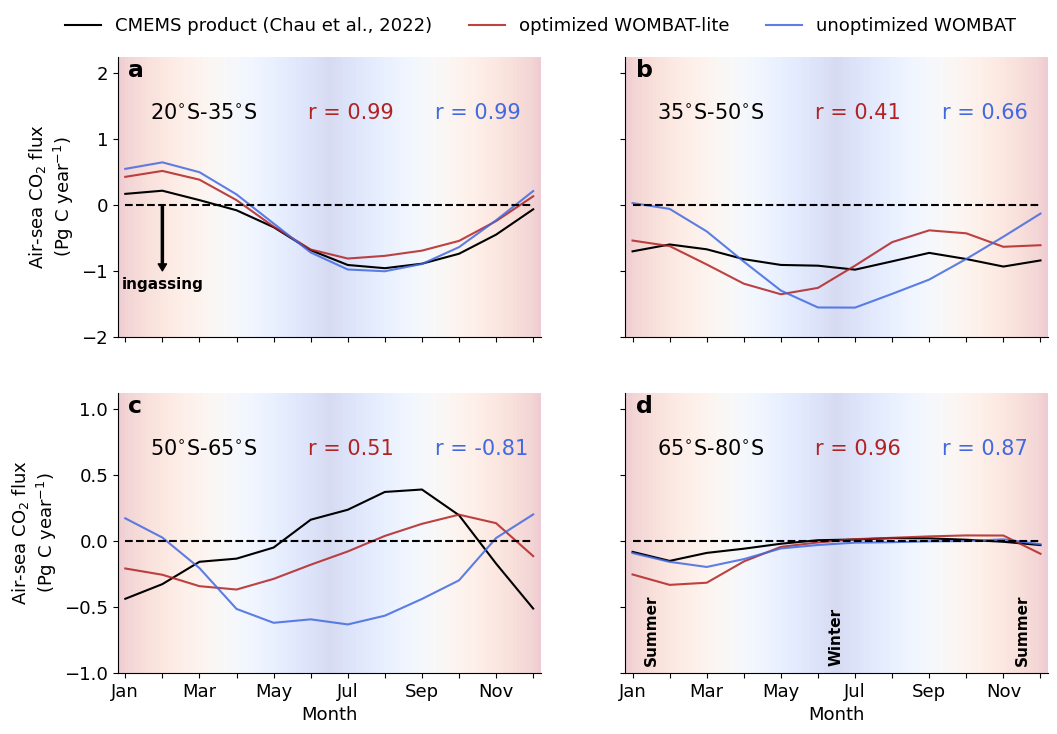

In [20]:
fig_co2season = plt.figure(figsize=(12,8))
gs = GridSpec(2,2)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])

ax1.spines[['top', 'right']].set_visible(False)
ax2.spines[['top', 'right']].set_visible(False)
ax3.spines[['top', 'right']].set_visible(False)
ax4.spines[['top', 'right']].set_visible(False)

ax1.tick_params(labelsize=fstic, labelbottom=False)
ax2.tick_params(labelsize=fstic, labelbottom=False, labelleft=False)
ax3.tick_params(labelsize=fstic)
ax4.tick_params(labelsize=fstic, labelleft=False)


#ax1.plot((co2_cop_reg_clim*area_reg).isel(y=slice(0,70)).sum(dim=['y','x'])*12*1e-15, color=cols[0], label=labs[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
#ax1.plot((aco2_mod_reg_clim*area_reg).isel(y=slice(0,70)).sum(dim=['y','x'])*12*1e-15, color=cols[1], label=labs[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])
#ax1.plot((aco2_old_reg_clim*area_reg).isel(y=slice(0,70)).sum(dim=['y','x'])*12*1e-15, color=cols[2], label=labs[2], linewidth=lwid[2], linestyle=lsty[2], alpha=alf[2])

ax1.plot(-(co2_cop_reg_clim*area_reg).isel(y=slice(55,70)).sum(dim=['y','x'])*12*1e-15, color=cols[0], label=labs[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
ax1.plot(-(aco2_mod_reg_clim*area_reg).isel(y=slice(55,70)).sum(dim=['y','x'])*12*1e-15, color=cols[1], label=labs[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])
ax1.plot(-(aco2_old_reg_clim*area_reg).isel(y=slice(55,70)).sum(dim=['y','x'])*12*1e-15, color=cols[2], label=labs[2], linewidth=lwid[2], linestyle=lsty[2], alpha=alf[2])

ax2.plot(-(co2_cop_reg_clim*area_reg).isel(y=slice(40,55)).sum(dim=['y','x'])*12*1e-15, color=cols[0], label=labs[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
ax2.plot(-(aco2_mod_reg_clim*area_reg).isel(y=slice(40,55)).sum(dim=['y','x'])*12*1e-15, color=cols[1], label=labs[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])
ax2.plot(-(aco2_old_reg_clim*area_reg).isel(y=slice(40,55)).sum(dim=['y','x'])*12*1e-15, color=cols[2], label=labs[2], linewidth=lwid[2], linestyle=lsty[2], alpha=alf[2])

ax3.plot(-(co2_cop_reg_clim*area_reg).isel(y=slice(25,40)).sum(dim=['y','x'])*12*1e-15, color=cols[0], label=labs[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
ax3.plot(-(aco2_mod_reg_clim*area_reg).isel(y=slice(25,40)).sum(dim=['y','x'])*12*1e-15, color=cols[1], label=labs[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])
ax3.plot(-(aco2_old_reg_clim*area_reg).isel(y=slice(25,40)).sum(dim=['y','x'])*12*1e-15, color=cols[2], label=labs[2], linewidth=lwid[2], linestyle=lsty[2], alpha=alf[2])

ax4.plot(-(co2_cop_reg_clim*area_reg).isel(y=slice(10,25)).sum(dim=['y','x'])*12*1e-15, color=cols[0], label=labs[0], linewidth=lwid[0], linestyle=lsty[0], alpha=alf[0])
ax4.plot(-(aco2_mod_reg_clim*area_reg).isel(y=slice(10,25)).sum(dim=['y','x'])*12*1e-15, color=cols[1], label=labs[1], linewidth=lwid[1], linestyle=lsty[1], alpha=alf[1])
ax4.plot(-(aco2_old_reg_clim*area_reg).isel(y=slice(10,25)).sum(dim=['y','x'])*12*1e-15, color=cols[2], label=labs[2], linewidth=lwid[2], linestyle=lsty[2], alpha=alf[2])

ax1.plot((0,11),(0,0), 'k--')
ax2.plot((0,11),(0,0), 'k--')
ax3.plot((0,11),(0,0), 'k--')
ax4.plot((0,11),(0,0), 'k--')
#ax5.plot((0,11),(0,0), 'k--')

y1 = -2.0; y2 = 2.25
ax1.set_ylim(y1,y2)
ax2.set_ylim(y1,y2)
ax3.set_ylim(y1*0.5,y2*0.5)
ax4.set_ylim(y1*0.5,y2*0.5)
#ax5.set_ylim(y1,y2)

xx=0.075;yy=0.8
#plt.text(xx,yy,"20$^{\circ}$S-80$^{\circ}$S", transform=ax1.transAxes, ha='left', va='center', fontsize=15)
plt.text(xx,yy,"20$^{\circ}$S-35$^{\circ}$S", transform=ax1.transAxes, ha='left', va='center', fontsize=15)
plt.text(xx,yy,"35$^{\circ}$S-50$^{\circ}$S", transform=ax2.transAxes, ha='left', va='center', fontsize=15)
plt.text(xx,yy,"50$^{\circ}$S-65$^{\circ}$S", transform=ax3.transAxes, ha='left', va='center', fontsize=15)
plt.text(xx,yy,"65$^{\circ}$S-80$^{\circ}$S", transform=ax4.transAxes, ha='left', va='center', fontsize=15)
xx=0.75;yy=0.8
#plt.text(xx,yy,"r = %.2f"%(r_SOCO2_20to80_old[0,1]), transform=ax1.transAxes, ha='left', va='center', fontsize=15, color=cols[2])
plt.text(xx,yy,"r = %.2f"%(r_SOCO2_20to35_old[0,1]), transform=ax1.transAxes, ha='left', va='center', fontsize=15, color=cols[2])
plt.text(xx,yy,"r = %.2f"%(r_SOCO2_35to50_old[0,1]), transform=ax2.transAxes, ha='left', va='center', fontsize=15, color=cols[2])
plt.text(xx,yy,"r = %.2f"%(r_SOCO2_50to65_old[0,1]), transform=ax3.transAxes, ha='left', va='center', fontsize=15, color=cols[2])
plt.text(xx,yy,"r = %.2f"%(r_SOCO2_65to80_old[0,1]), transform=ax4.transAxes, ha='left', va='center', fontsize=15, color=cols[2])
xx=0.45;yy=0.8
#plt.text(xx,yy,"r = %.2f"%(r_SOCO2_20to80_new[0,1]), transform=ax1.transAxes, ha='left', va='center', fontsize=15, color=cols[1])
plt.text(xx,yy,"r = %.2f"%(r_SOCO2_20to35_new[0,1]), transform=ax1.transAxes, ha='left', va='center', fontsize=15, color=cols[1])
plt.text(xx,yy,"r = %.2f"%(r_SOCO2_35to50_new[0,1]), transform=ax2.transAxes, ha='left', va='center', fontsize=15, color=cols[1])
plt.text(xx,yy,"r = %.2f"%(r_SOCO2_50to65_new[0,1]), transform=ax3.transAxes, ha='left', va='center', fontsize=15, color=cols[1])
plt.text(xx,yy,"r = %.2f"%(r_SOCO2_65to80_new[0,1]), transform=ax4.transAxes, ha='left', va='center', fontsize=15, color=cols[1])

xx=0.025;yy=0.95
plt.text(xx,yy,"a", transform=ax1.transAxes, ha='left', va='center', fontsize=17, fontweight='bold')
plt.text(xx,yy,"b", transform=ax2.transAxes, ha='left', va='center', fontsize=17, fontweight='bold')
plt.text(xx,yy,"c", transform=ax3.transAxes, ha='left', va='center', fontsize=17, fontweight='bold')
plt.text(xx,yy,"d", transform=ax4.transAxes, ha='left', va='center', fontsize=17, fontweight='bold')

ax1.legend(frameon=False, loc='upper center', bbox_to_anchor=(1.0,1.2), ncol=3, fontsize=fstic)

ax1.set_xticks(np.arange(0,12,1), np.array(['Jan', ' ', 'Mar', ' ', 'May', ' ', 'Jul', ' ', 'Sep', ' ', 'Nov', ' ']))
ax2.set_xticks(np.arange(0,12,1), np.array(['Jan', ' ', 'Mar', ' ', 'May', ' ', 'Jul', ' ', 'Sep', ' ', 'Nov', ' ']))
ax3.set_xticks(np.arange(0,12,1), np.array(['Jan', ' ', 'Mar', ' ', 'May', ' ', 'Jul', ' ', 'Sep', ' ', 'Nov', ' ']))
ax4.set_xticks(np.arange(0,12,1), np.array(['Jan', ' ', 'Mar', ' ', 'May', ' ', 'Jul', ' ', 'Sep', ' ', 'Nov', ' ']))

ax3.set_xlabel("Month", fontsize=fslab-2)
ax4.set_xlabel("Month", fontsize=fslab-2)
ax1.set_ylabel("Air-sea CO$_2$ flux\n(Pg C year$^{-1}$)", fontsize=fslab-2)
ax3.set_ylabel("Air-sea CO$_2$ flux\n(Pg C year$^{-1}$)", fontsize=fslab-2)

ax1.annotate(
    '',  # Text to display
    xy=(1.0,-1.0),   # The arrowhead location
    xytext=(1.0,0.0),  # The starting point of the arrow
    xycoords='data',
    size=2,
    arrowprops=dict(facecolor='k', headwidth=6, shrink=0.0, headlength=5, width=1.5),
)

plt.text(1,-1.2, 'ingassing', fontsize=fstic-2, fontweight='bold', ha='center', va='center', transform=ax1.transData)


xgrad, ygrad = np.meshgrid(np.concatenate((np.arange(0,6,0.1), np.arange(6,-0.1,-0.1))), np.arange(-3,3.1,0.1))
ax1.imshow(xgrad, extent=[-0.2,11.2,-3,3], origin='lower', aspect='auto', cmap='coolwarm_r', alpha=0.2)
ax2.imshow(xgrad, extent=[-0.2,11.2,-3,3], origin='lower', aspect='auto', cmap='coolwarm_r', alpha=0.2)
ax3.imshow(xgrad, extent=[-0.2,11.2,-3,3], origin='lower', aspect='auto', cmap='coolwarm_r', alpha=0.2)
ax4.imshow(xgrad, extent=[-0.2,11.2,-3,3], origin='lower', aspect='auto', cmap='coolwarm_r', alpha=0.2)

plt.text(0.5,-0.95, 'Summer', fontsize=fstic-2, fontweight='bold', ha='center', va='bottom', transform=ax4.transData, rotation=90)
plt.text(5.5,-0.95, 'Winter', fontsize=fstic-2, fontweight='bold', ha='center', va='bottom', transform=ax4.transData, rotation=90)
plt.text(10.5,-0.95, 'Summer', fontsize=fstic-2, fontweight='bold', ha='center', va='bottom', transform=ax4.transData, rotation=90)


fig_co2season.savefig("figures/hindcast_co2fluxes-seasonalco2.png", dpi=300)
fig_co2season.savefig("figures/hindcast_co2fluxes-seasonalco2.pdf", dpi=300)
fig_co2season.savefig("figures/hindcast_co2fluxes-seasonalco2_transparent.png", dpi=300, transparent=True)



### perform the running correlation and standard error calculations month by month

In [21]:
new_corr_space = xr.corr(aco2_mod_reg, co2_cop_reg, dim='month')
new_corr_time = xr.corr(aco2_mod_reg, co2_cop_reg, dim=['y','x'])

new_corr_time_south = xr.corr(aco2_mod_reg.where(lat_reg<-30, other=np.nan, drop=True), co2_cop_reg.where(lat_reg<-30, other=np.nan, drop=True), dim=['y','x'])
new_corr_time_tropi = xr.corr(aco2_mod_reg.where((lat_reg > -30) & (lat_reg < 30), other=np.nan, drop=True), co2_cop_reg.where((lat_reg > -30) & (lat_reg < 30), other=np.nan, drop=True), dim=['y','x'])
new_corr_time_north = xr.corr(aco2_mod_reg.where(lat_reg>30, other=np.nan, drop=True), co2_cop_reg.where(lat_reg>30, other=np.nan, drop=True), dim=['y','x'])

old_corr_space = xr.corr(aco2_old_reg, co2_cop_reg, dim='month')
old_corr_time = xr.corr(aco2_old_reg, co2_cop_reg, dim=['y','x'])

old_corr_time_south = xr.corr(aco2_old_reg.where(lat_reg<-30, other=np.nan, drop=True), co2_cop_reg.where(lat_reg<-30, other=np.nan, drop=True), dim=['y','x'])
old_corr_time_tropi = xr.corr(aco2_old_reg.where((lat_reg > -30) & (lat_reg < 30), other=np.nan, drop=True), co2_cop_reg.where((lat_reg > -30) & (lat_reg < 30), other=np.nan, drop=True), dim=['y','x'])
old_corr_time_north = xr.corr(aco2_old_reg.where(lat_reg>30, other=np.nan, drop=True), co2_cop_reg.where(lat_reg>30, other=np.nan, drop=True), dim=['y','x'])


In [22]:
ds_ = xr.Dataset(
    {'corr_new': ( ('y', 'x'), new_corr_space.values),
     'corr_old': ( ('y', 'x'), old_corr_space.values),
     },
    coords={"lon": (['x'], lon_reg.isel(y=0).values),
            "lat": (['y'], lat_reg.isel(x=0).values),
           }
)

print("adding cyclic point")
from cartopy.util import add_cyclic_point

corr_new_cyclic, lon_cyclic = add_cyclic_point(ds_['corr_new'], coord=ds_['corr_new'].coords['lon'])
corr_old_cyclic, lon_cyclic = add_cyclic_point(ds_['corr_old'], coord=ds_['corr_new'].coords['lon'])


adding cyclic point


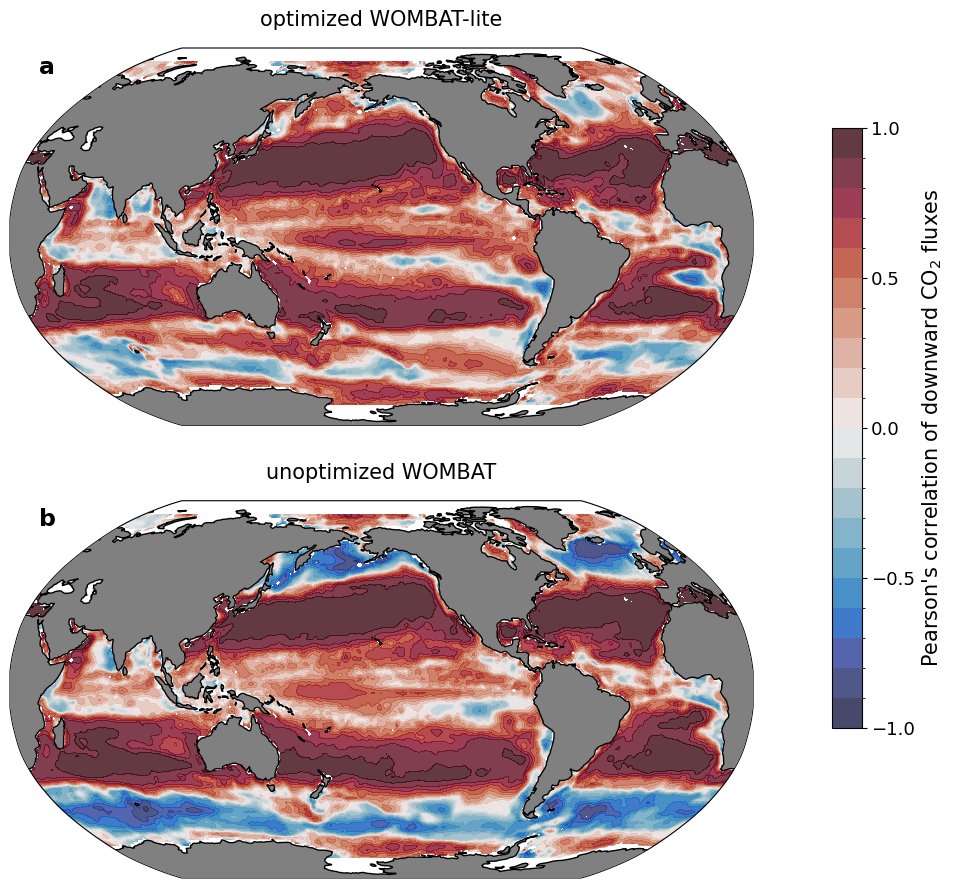

In [23]:
fslab = 15
fstic = 13

import matplotlib.lines as mlines
from cartopy.util import add_cyclic_point

proj = ccrs.Robinson(central_longitude=205)

colmap1 = lighten(cmo.balance, 0.8) #NO3

# chlorophyll
levs1 = np.arange(-10,11,1)*0.1
norm1 = mcolors.BoundaryNorm(levs1, ncolors=256)

fig = plt.figure(figsize=(12,10), facecolor='w')
gs = GridSpec(2, 1)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[1,0], projection=proj)


p1 = ax1.contourf(lon_cyclic, lat_reg.isel(x=0), corr_new_cyclic, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='neither')
p2 = ax2.contourf(lon_cyclic, lat_reg.isel(x=0), corr_old_cyclic, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='neither')

ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax1.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax2.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax2.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)

plt.text(0.5, 1.075, 'optimized WOMBAT-lite', va='center', ha='center', fontsize=fslab, transform=ax1.transAxes)
plt.text(0.5, 1.075, 'unoptimized WOMBAT', va='center', ha='center', fontsize=fslab, transform=ax2.transAxes)

cbax1 = fig.add_axes([0.85, 0.2, 0.025, 0.6])
cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::5])
cbar1.ax.tick_params(labelsize=fstic)
cbar1.ax.set_ylabel("Pearson's correlation of downward CO$_2$ fluxes", fontsize=fslab)

plt.subplots_adjust(left=0.05, right=0.9, bottom=0.05)
xx = 0.05
yy = 0.95
plt.text(xx,yy, 'a', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax1.transAxes)
plt.text(xx,yy, 'b', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax2.transAxes)


os.chdir(wrkdir)
fig.savefig("figures/hindcast_co2fluxes-correlation.png", dpi=300)
fig.savefig("figures/hindcast_co2fluxes-correlation.pdf", dpi=300)
fig.savefig("figures/hindcast_co2fluxes-correlation_transparent.png", dpi=300, transparent=True)
